<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

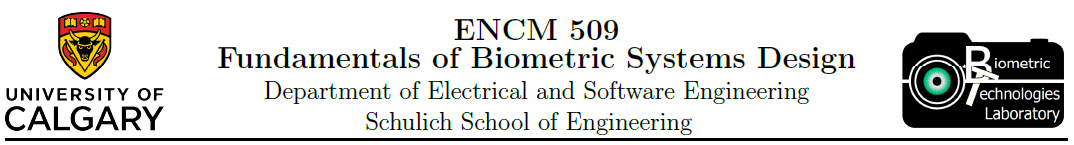

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
1. Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section). (10 marks)
1. Conclusion (a paragraph on what is the main take-out of the lab).

### Introduction

In this lab we are investigating some techniques of how facial recognition works. This will involve Principal Component Analysis, threshold-based face matching and a simple KNN. We will adjust some of the values to see what effect they have on the final accuracy of the model.

- **Exercise 1** (3 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases': face known to the gallery, face unknown to the gallery and not a face, as shown in Fig. 2 of the lab handout. However, you need to choose  two or three different subjects (for example, subjects 2, 3 and 4)  from the dataset (gallery), or create your own. Use the first 9 images of each subject to build the gallery. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each  image is a sample, or input (no separate model is built per subject).

    Now, choose the probe images as follows: 
    1. The 10th image of each of the three  subjects  in the gallery.
    1. 2-3  faces of the subjects not known to the gallery.
    1. 1-2 not-a-face image. 

    For each of the  comparisons, save the Euclidean distances calculated, and mark the minimum and maximum value in each case.

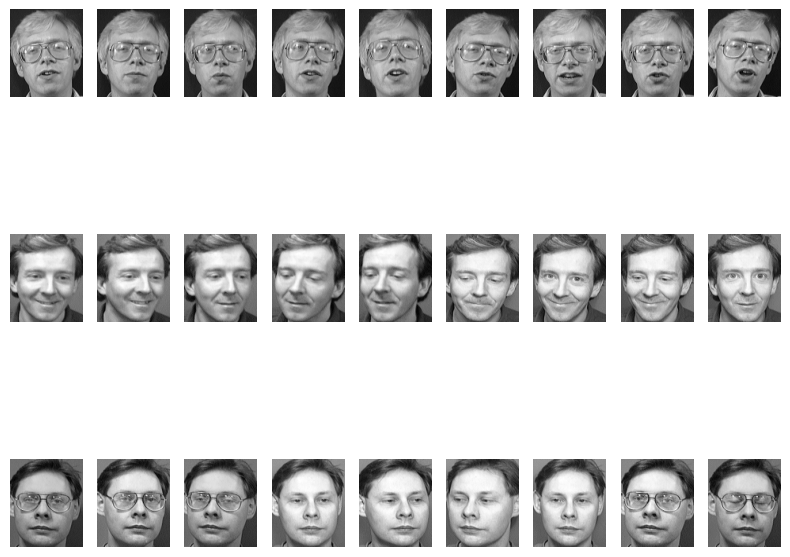

In [2]:
# Create gallery 
M = 27

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread('./ATT dataset/s1/1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))

n = 0
for j in range(2, 4+1):  # three subjects
    for i in range(1,9+1):  # 9 images from each subject 
        path = './ATT dataset/s' + str(j) + '/' + str(i) + '.pgm'
        img = imread(path, as_gray=True)
        temp = np.reshape(img, (irow*icol,1))
        S[:,n] = temp[:,0] 
        n = n + 1
        
        plt.subplot(3,9,n)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    

In [3]:
# Noramlize 
um = 100
ustd = 80

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

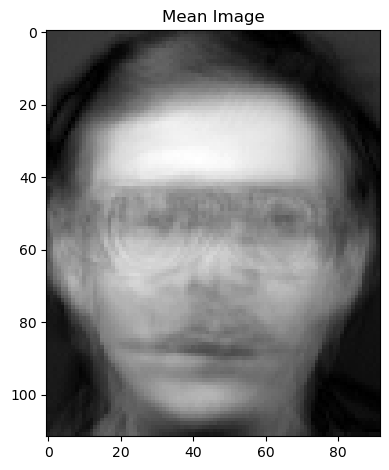

In [4]:
# Calulcate mean face 

# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

In [5]:
#### Creating covariance matrix  L

dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

#### Sort and eliminate zero eigenvalue

v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

#### Normalization of eigenvectors

for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

/var/folders/hy/3zt6fpm52v137lbvptw6fkjr0000gp/T/ipykernel_37323/2465110001.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


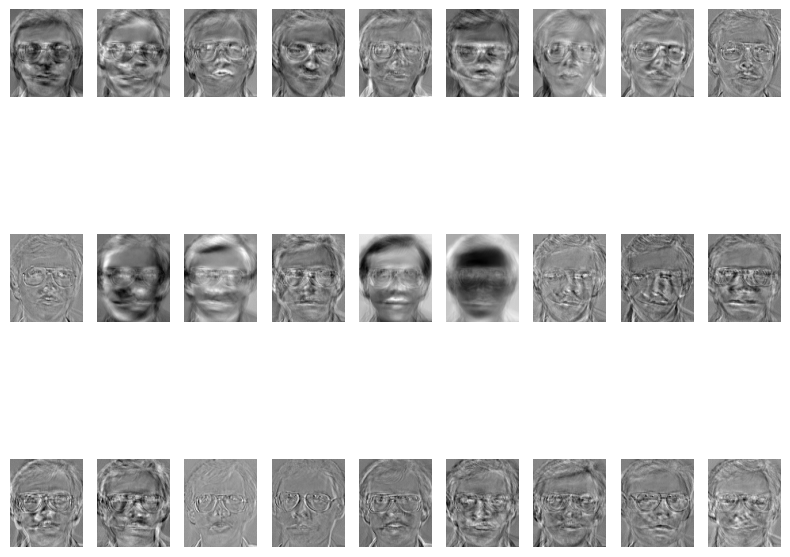

In [6]:
#### Showing eigenfaces

plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,9,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


In [7]:
#### Find the weight of each face in the training set

omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

In [8]:
# Matching 

def matching(path, u, m): 
    InputImage = imread(path, as_gray=True)
    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference: NormalizedImage - MeanImage
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for i in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,i], NormImage) 
        p[i] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    InImWeight = np.zeros((M,1))

    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        # scalar vector product of vectors t and Difference
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage

    #### Finding the Euclidean distance

    Probe = np.zeros((M,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        Probe[i] = mag

    # max/min Euclidean distance
    MaximumValue = np.max(Probe) 
    MinimumValue = np.min(Probe) 

    labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', 
             '27')

    plt.bar(np.arange(len(Probe)), Probe.flatten(), tick_label=labels)
    plt.ylim([10000, 16000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Image: ' + path + '\n'\
              'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));
    
    return MaximumValue, MinimumValue, Probe


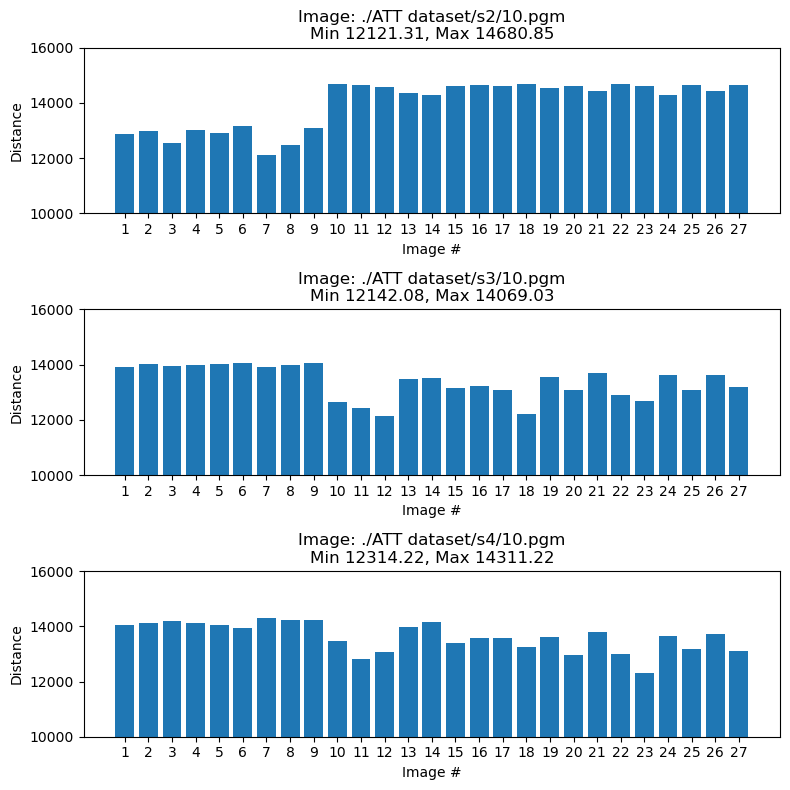

In [9]:
# Faces known to gallery

plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
max1, min1, dist1 = matching('./ATT dataset/s2/10.pgm', u, m)
plt.subplot(3,1,2)
max2, min2, dist2 = matching('./ATT dataset/s3/10.pgm', u, m)
plt.subplot(3,1,3)
max3, min3, dist3 = matching('./ATT dataset/s4/10.pgm', u, m)

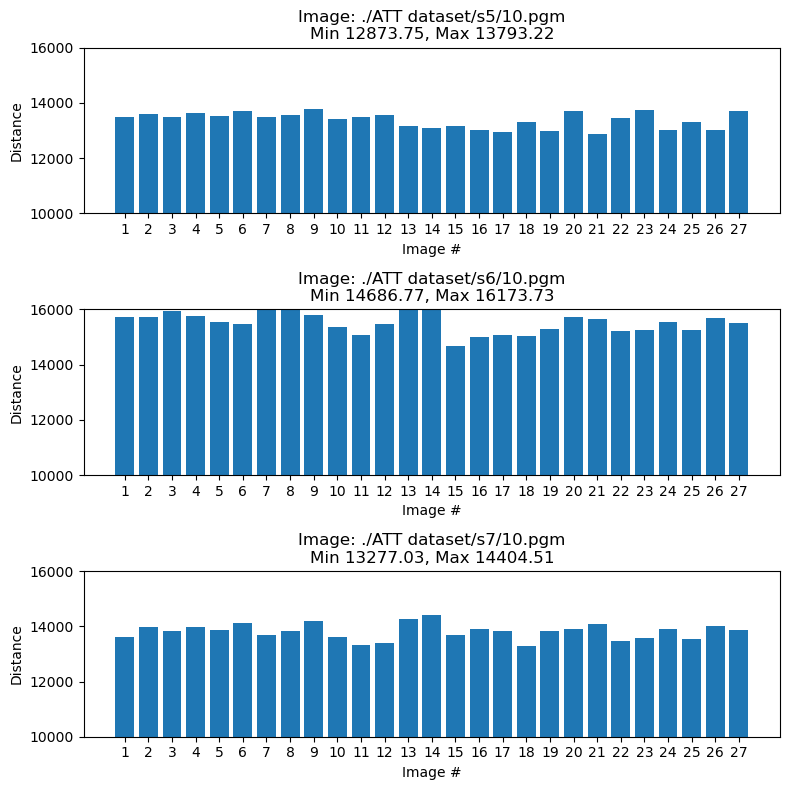

In [10]:
# Faces unknown to gallery

plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
max4, min4, dist4 = matching('./ATT dataset/s5/10.pgm', u, m)
plt.subplot(3,1,2)
max5, min5, dist5 = matching('./ATT dataset/s6/10.pgm', u, m)
plt.subplot(3,1,3)
max6, min6, dist6 = matching('./ATT dataset/s7/10.pgm', u, m)

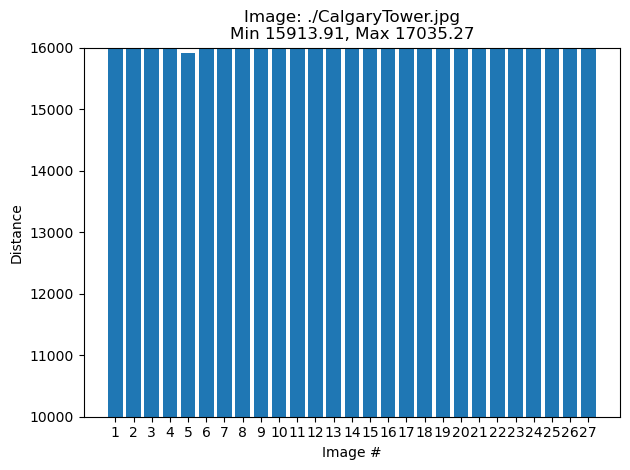

In [11]:
# Not a face
max7, min7, dist7 = matching('./CalgaryTower.jpg', u, m)

All three of the subjects known to the gallery had similar min and max distances of 12000 and 14400 respectively. Subjects 5 and 7 had similar distances to the known subjects. This could result in them being misclassified as subjects in the gallery. In contrast subject 6 had higher distances indicating it is not a knwon person. The image of the calgary tower had the highest distances indicating it was least similar to the faces in the gallery.

- **Exercise 2** (3 marks): Determine the first and the second thresholds; hint: analyze the   maximum of the Euclidean distances  for the probe images known to the dataset. 
		
    To find the second threshold, use unknown faces as the input faces and gather all the  Euclidean distance. Hint: consider the maximum as the second threshold, but also analyze other values.

In [12]:
# Set threshold 1 to the average of max values from known subjects 
threshold1 = np.mean([max1, max2, max3])
threshold2 = np.mean([max4, max5, max6])

print("Threshold 1: " + str(threshold1))
print("Threshold 2: " + str(threshold2) + "\n")

distances = [dist1, dist2, dist3, dist4, dist5, dist6, dist7]

for i in distances:
    mean_of_distances = np.mean(i);
    if (mean_of_distances <= threshold1):
        print('Image is in the database')
    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Image is a face but not in the database')
    elif (mean_of_distances > threshold2):
        print('Image is not a face')

Threshold 1: 14353.69893355853
Threshold 2: 14790.487809360979

Image is in the database
Image is in the database
Image is in the database
Image is in the database
Image is not a face
Image is in the database
Image is not a face


In [13]:
# Set threshold 1 to the average of max values from known subjects 
threshold1 = 13550 
threshold2 = np.mean([min7])

print("Threshold 1: " + str(threshold1))
print("Threshold 2: " + str(threshold2) + "\n")

distances = [dist1, dist2, dist3, dist4, dist5, dist6, dist7]

for i in distances:
    mean_of_distances = np.mean(i);
    if (mean_of_distances <= threshold1):
        print('Image is in the database')
    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Image is a face but not in the database')
    elif (mean_of_distances > threshold2):
        print('Image is not a face')

Threshold 1: 13550
Threshold 2: 15913.90583659779

Image is a face but not in the database
Image is in the database
Image is a face but not in the database
Image is in the database
Image is a face but not in the database
Image is a face but not in the database
Image is not a face


We first set threshold 1 and 2 to the average of max distances for known and unkown subjects respectively. This resulted in the first three images correctly identified as in the database. However, all of the faces unkown to the database are incorrectly classifed. This is because Subject 5 and 7 and have low distance scores while subject 6 has high scores. It is very difficult to correctly classify each face because you need a very wide window between threshold 1 and 2. The image that is not a face has much higher score than all the other images making it easy to classify. 

- **Exercise 3** (2 marks): In the description of the face recognition using PCA and KNN above, the PCA was used with 100 principal components. Now repeat the same procedure using 50 and 200 principal components. Evaluate the resulting classifier  accuracy, using Confusion matrix. Visualize the comparison using either a table or a bar plot (comparing the results for the three number of components: 50, 100 (already done) and 200). 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [15]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong)
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))
    return (acc*100,TPR*100, TNR*100, FPR*100, FNR*100)

Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


/usr/local/anaconda3/envs/encm509-2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


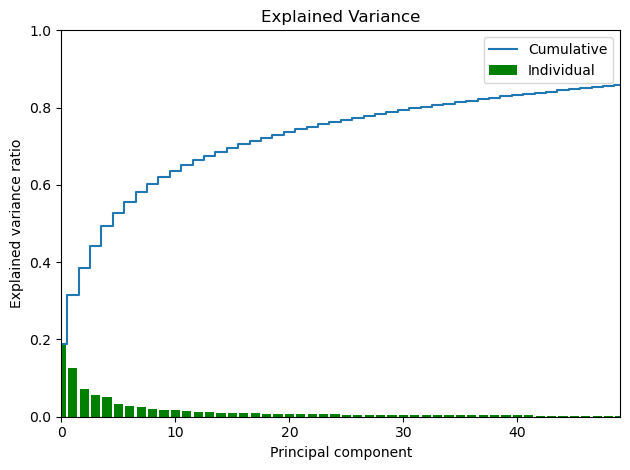

/usr/local/anaconda3/envs/encm509-2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


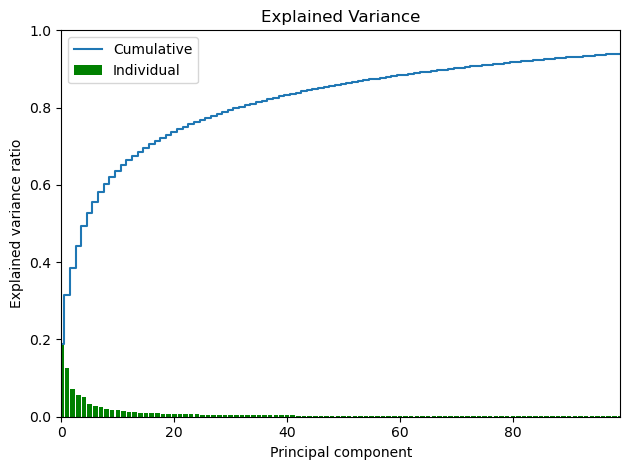

/usr/local/anaconda3/envs/encm509-2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


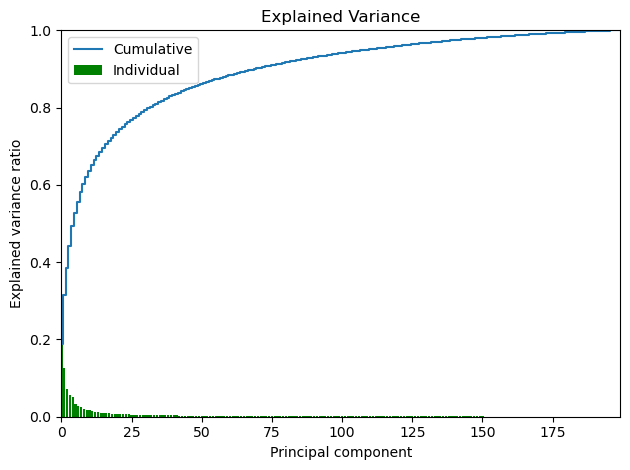

,pca_principal_components,acc,TPR,TNR,FPR,FNR
0,50,85.0,80.0,100.0,0.0,20.0
1,100,86.0,80.0,100.0,0.0,20.0
2,200,86.0,80.0,100.0,0.0,20.0


In [16]:
data = []

for idx,n_components_pca in enumerate([50, 100, 200]):
    n_subjects = 40

    # number of images should sum to 10
    n_training_images = 5
    n_test_images = 5

    knn_neighbors = 3

    # You can specify you directory here, please, change the string below:
    path = '../ATT dataset/'

    # print('For EACH of all the %d subjects:' % (n_subjects))
    # print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
    # print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

    # use the first 5 images from subjectID 1-n_subjects to train the classifier
    trainingFaces = []
    trainingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(1, n_training_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            trainingFaces.append(np.reshape(img, (img.size,)))
            trainingLabels.append(subjectId)

    # use the last 5 images from subjectID 1-20 to test the classifier
    testingFaces = []
    testingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            testingFaces.append(np.reshape(img, (img.size,)))
            testingLabels.append(subjectId)
    # print('Training faces:', len(trainingFaces))
    # print('Size of each sample:', len(trainingFaces[0]))
    ### Initializing the PCA
    # n_components: number of principal components
    # n_components_pca = 100
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces);
    #### Apply PCA to the two sets: Training and Test
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)

    ### Training the KNN
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    ### Evaluating the Results
    data.append([n_components_pca] + list(prediction_evaluation(predictedLabels, testingLabels)))
    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

    # plot_confusion_matrix(cm=confusionMatrix,
    #                       target_names = [i for i in range(1, n_subjects+1)], title=f'Confusion Matrix with {n_components_pca} pca components')

    lst_components = range(pca.n_components_)

    pca_explained_var = pca.explained_variance_ratio_
    
    # Cumulative sum of eigenvalues
    cum_sum_eigenvalues = np.cumsum(pca_explained_var)

    plt.bar(lst_components, pca_explained_var, label='Individual', color='green')
    plt.step(lst_components, cum_sum_eigenvalues, where='mid', label='Cumulative')
    plt.title('Explained Variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component')
    plt.legend()
    plt.xlim([0, n_components_pca-1])
    plt.ylim([0,1])
    plt.show()


import pandas as pd

dataframe_data = {'pca_principal_components': [x[0] for x in data],
                  'acc': [x[1] for x in data],
                  'TPR': [x[2] for x in data],
                  'TNR': [x[3] for x in data],
                  'FPR': [x[4] for x in data],
                  'FNR': [x[5] for x in data]
}

pd.DataFrame(data=dataframe_data)



|pca_principal_components|   acc|   TPR|    TNR | FPR|   FNR|
|---|---|---|---|---|---|
|                      50|  85.0|  80.0|  100.0| 0.0|  20.0|
|                     100|  86.0|  80.0|  100.0| 0.0|  20.0|
|                     200|  86.0|  80.0|  100.0| 0.0|  20.0|

**Exercise 3 discussion:**
Changing the number of principal components does not change the accuracy significantly. However it does tell us a good number of principal components to be used. Having too few principal components can over simplify the image while having too many principal components will hurt performance significantly with little to gain in accuracy. The Explained Variance graphs above help to determine a good principal component number.

- **Exercise 4** (2 marks): Evaluate the impact of the number of neighbors $(K)$ defined for the KNN. Using the same data separation  (20 subjects, 8 images per subject are used for training and 2 for testing), conduct the two  experiments considering, for example: 1) 5 neighbors and, 2) 11 neighbors.  Compare the KNN classifier results, using Confusion matrices, and draw the conclusions.

/usr/local/anaconda3/envs/encm509-2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


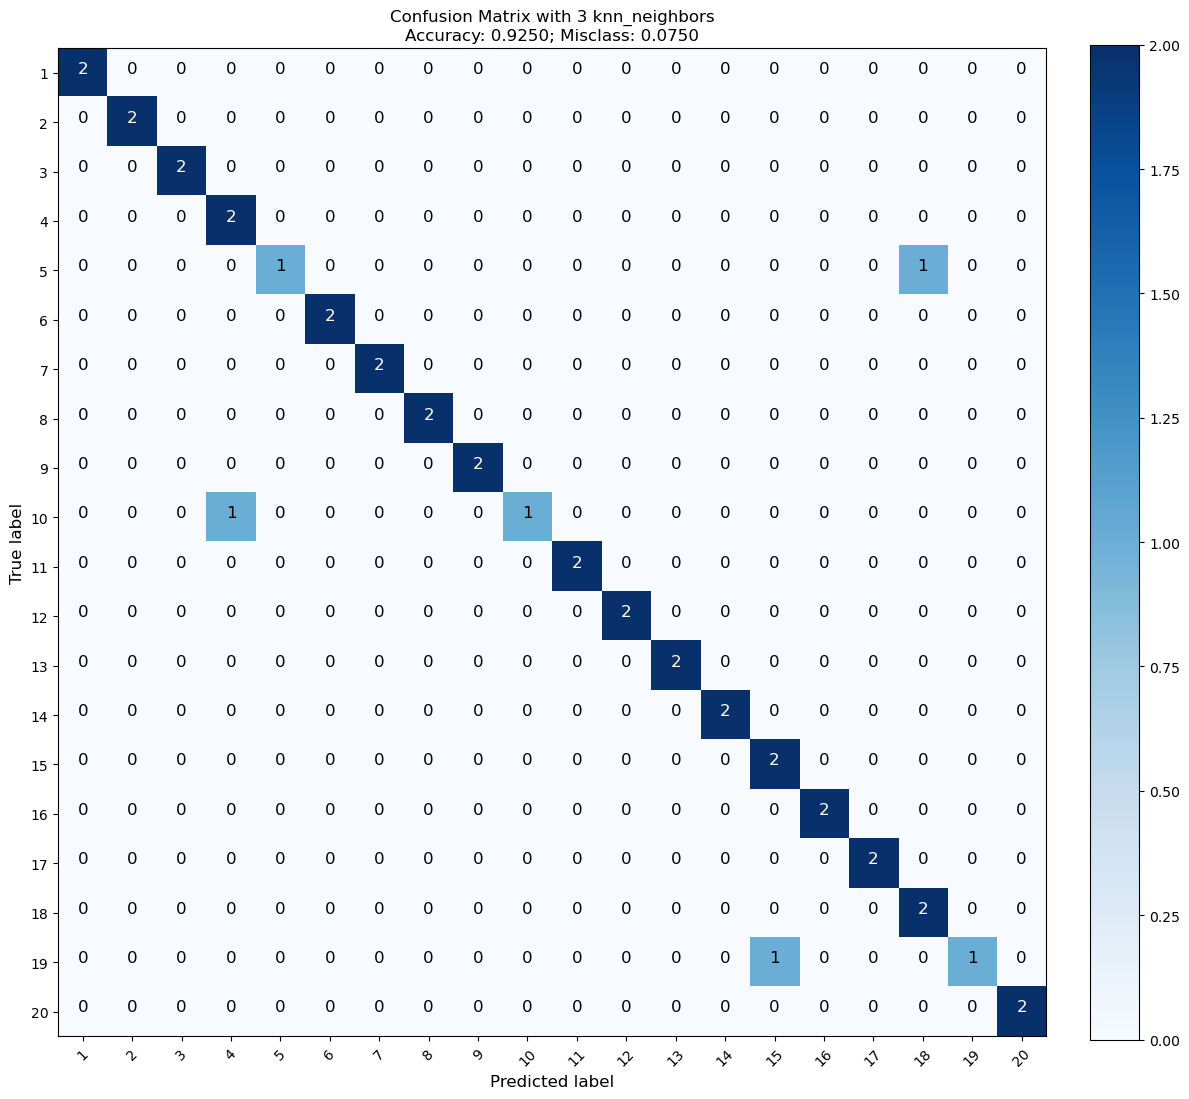

/usr/local/anaconda3/envs/encm509-2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


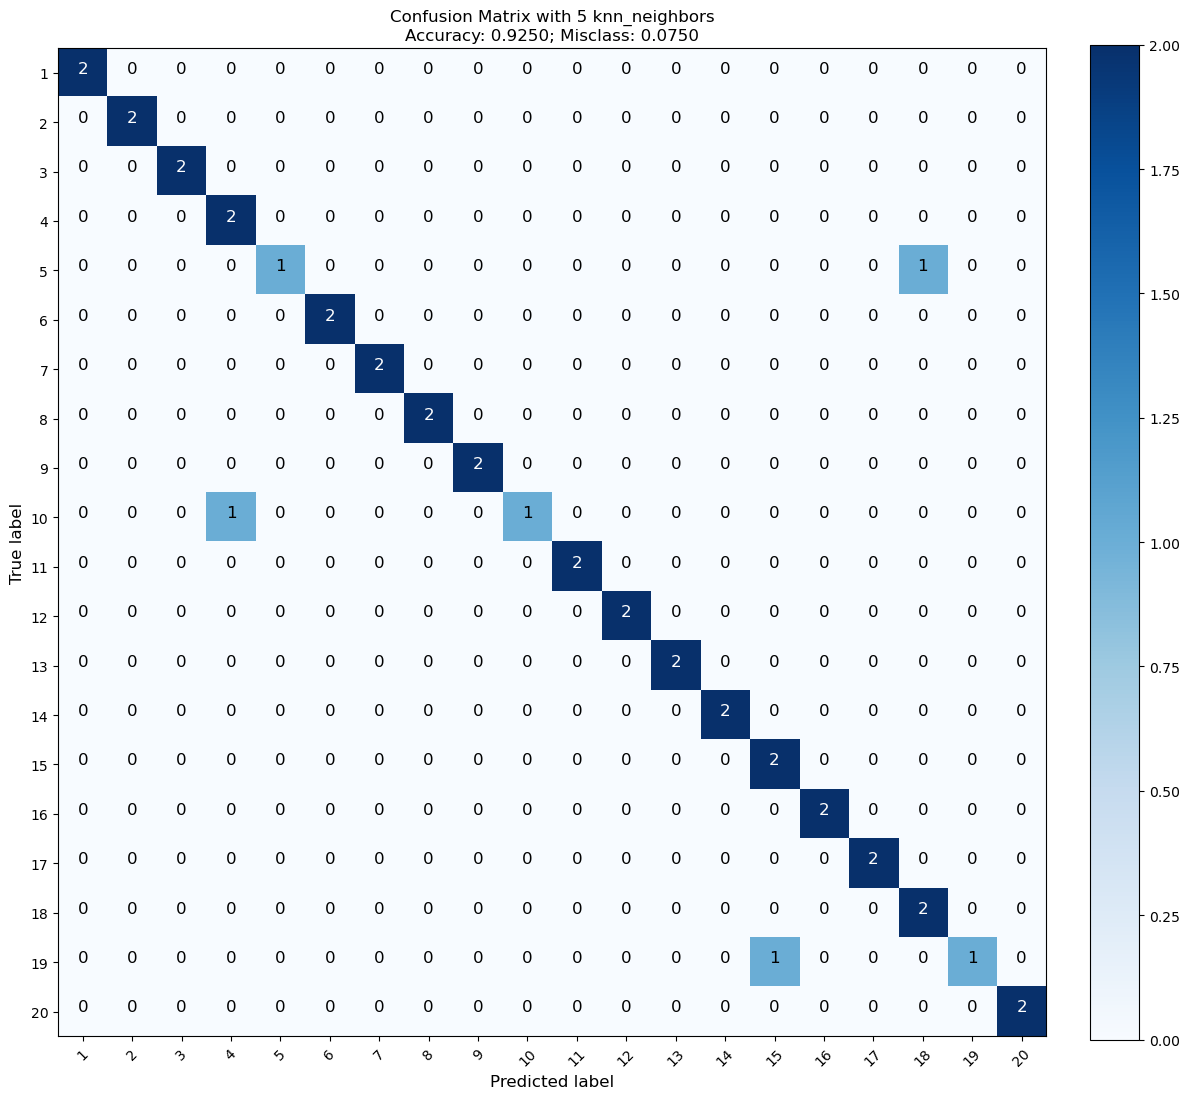

/usr/local/anaconda3/envs/encm509-2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 80%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


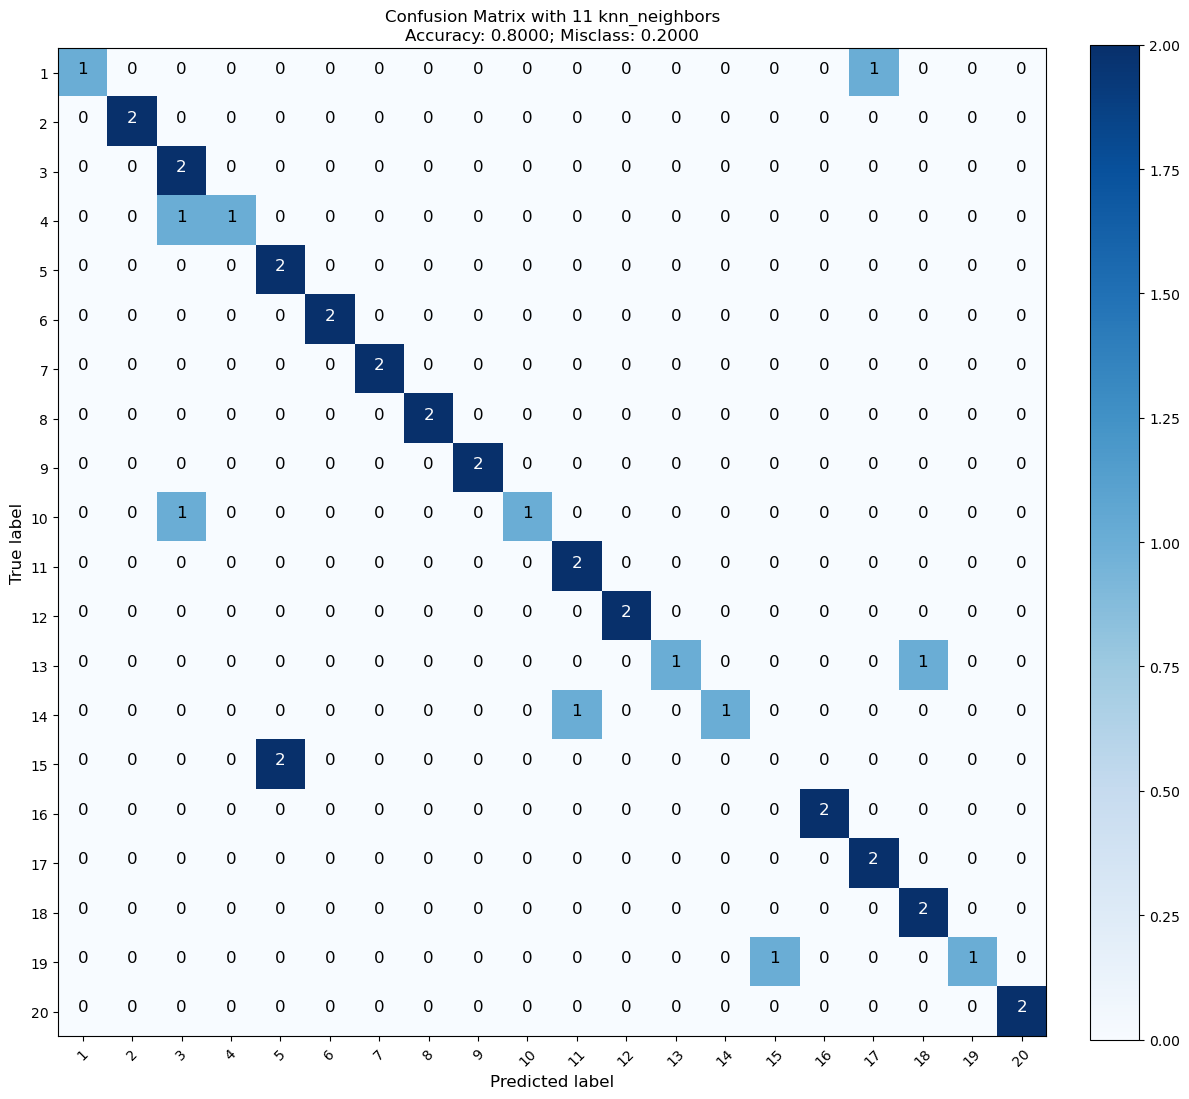

,knn_neighbors,acc,TPR,TNR,FPR,FNR
0,3,92.5,100.0,100.0,0.0,0.0
1,5,92.5,100.0,100.0,0.0,0.0
2,11,80.0,50.0,100.0,0.0,50.0


In [17]:
data = []

for knn_neighbors in [3, 5, 11]:
    n_subjects = 20

    # number of images should sum to 10
    n_training_images = 8
    n_test_images = 2

    # knn_neighbors = 3

    # You can specify you directory here, please, change the string below:
    path = '../ATT dataset/'

    # print('For EACH of all the %d subjects:' % (n_subjects))
    # print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
    # print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

    # use the first 5 images from subjectID 1-n_subjects to train the classifier
    trainingFaces = []
    trainingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(1, n_training_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            trainingFaces.append(np.reshape(img, (img.size,)))
            trainingLabels.append(subjectId)

    # use the last 5 images from subjectID 1-20 to test the classifier
    testingFaces = []
    testingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            testingFaces.append(np.reshape(img, (img.size,)))
            testingLabels.append(subjectId)
    # print('Training faces:', len(trainingFaces))
    # print('Size of each sample:', len(trainingFaces[0]))
    ### Initializing the PCA
    # n_components: number of principal components
    n_components_pca = 100
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces);
    #### Apply PCA to the two sets: Training and Test
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)

    ### Training the KNN
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    ### Evaluating the Results
    data.append([knn_neighbors] + list(prediction_evaluation(predictedLabels, testingLabels)))
    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

    plot_confusion_matrix(cm=confusionMatrix,
                          target_names = [i for i in range(1, n_subjects+1)], title=f'Confusion Matrix with {knn_neighbors} knn_neighbors')

import pandas as pd

dataframe_data = {'knn_neighbors': [x[0] for x in data],
                  'acc': [x[1] for x in data],
                  'TPR': [x[2] for x in data],
                  'TNR': [x[3] for x in data],
                  'FPR': [x[4] for x in data],
                  'FNR': [x[5] for x in data]
}

pd.DataFrame(data=dataframe_data)

|   knn_neighbors  |  acc  |  TPR  |  TNR | FPR |  FNR|
|---|---|---|---|---|---|
 |            3  |92.50 | 100.0 | 100.0 | 0.0 |  0.0|
 |             5 | 92.50 | 100.0 | 100.0 | 0.0  | 0.0|
 |           11 | 77.5 |  50.0 | 100.0|  0.0 | 50.0|

**Exercise 4 discussion:**
In the above table we can see that using 3 and 5 nearest neighbors will cause the model to have high accuracy. But once we increase the value to 11 it causes the model to preform poorly (as evident in the last confusion matrix and accuracy score). Using a lower number for the nearest neighbors will ensure that the classifier is just using the best information to make the classification. If we increase the number of nearest neighbors it looks at by too much it will begin looking at lower quality information that can misclassify the subject.


# Conclusion

In this lab we looked at how facial recognition works using a computer. We looked few different techniques that help to classifying the images. These are Principal Component Analysis, threshold face matching and a simple KNN classifier using with the help of PCA. We investigated what will happen if we adjust the parameters and the influence that will have on the accuracy of the model.